In [1]:
import ehtplot
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

from astropy import units as u

from common  import hallmark as hm

from common  import dalt
from common  import dalt as d
from common  import viz
from common  import io_ipole as io

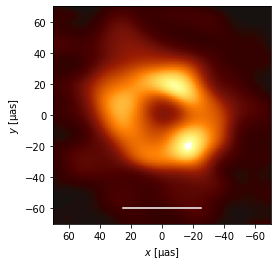

In [2]:
with fits.open('data/img-results/ring1.fits') as hdul:
    img_obs = dalt.Image(hdul[0].data.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0, 79.52842452054078 * 140 / 400, 79.52842452054078 * 140 / 400)
    
fig, ax = plt.subplots(1,1)
viz.show(img_obs, ax=ax, cmap='afmhot_10us')
ax.plot([-25,25], [-60,-60], 'w')

In [19]:
from copy import copy
from math import ceil
from astropy import units
from common import mockservation as ms

def truncation_scale(tolerant=0.01, n=2):
    return (1/(tolerant*tolerant) - 1)**(0.5/n)

def compress(imgs, N=None, eht_f=15e9):
    meta = copy(imgs.meta)
    fov  = imgs.fov.to(units.rad).value
    
    spec, U, V = ms.upfft(imgs, *fov, N=N)
    
    u = np.linspace(-U/2,U/2,spec.shape[-2],endpoint=False)
    v = np.linspace( 0,  V/2,spec.shape[-1])
    u, v = np.meshgrid(u, v, indexing='ij')
    
    n  = 2
    rr = (u*u + v*v) / (eht_f*eht_f)
    Bw = 1 / np.sqrt(1 + rr**n)
    
    I, W, H = ms.downifft(spec * Bw[np.newaxis,:,:], U, V)
    
    meta.width  = abs(W * meta.dist).to(meta.rg)
    meta.height = abs(H * meta.dist).to(meta.rg)
    return dalt.Image(I, meta=meta)

In [93]:
pf = hm.ParaFrame('model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s{snapshot}_Rh160_i30.h5')
mov = io.load_mov(tqdm(pf.path.iloc[:10]))

mov[:,:200,:] = 0
mov[:,202:,:] = 0
mov[:,:,:200] = 0
mov[:,:,202:] = 0

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 77.22it/s]


(400, 400) -> [400 400]
(400, 400) -> [400 400]
(5.863414870512292e-12, -0.49915868984636147, 0.5004530392337405, 8.514657103619939, 8.51464355321829, -44.93775869320602)
(5.863414870512292e-12, -0.49915868984636147, 0.5004530392337405, 20.050485224169396, 20.05045331541198, -44.93775869320602)


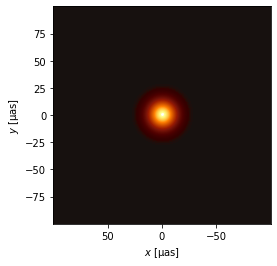

In [116]:
from common import analyses

def compress2(imgs, N=None, sigma=1/(168 * u.uas.to(u.rad))):
    meta = copy(imgs.meta)
    fov  = imgs.fov.to(units.rad).value
    
    spec, U, V = ms.upfft(imgs, *fov, N=N)
    
    u = np.linspace(-U/2,U/2,spec.shape[-2],endpoint=False)
    v = np.linspace( 0,  V/2,spec.shape[-1])
    u, v = np.meshgrid(u, v, indexing='ij')

    G  = np.exp(-(u*u + v*v) / (2 * np.pi * np.pi * sigma * sigma))
    
    I, W, H = ms.downifft(spec * G[np.newaxis,:,:], U, V)
    
    meta.width  = abs(W * meta.dist).to(meta.rg)
    meta.height = abs(H * meta.dist).to(meta.rg)
    return dalt.Image(I, meta=meta)

mov_eht2 = compress2(mov)
viz.show(mov_eht2, s=0, cmap='afmhot_10us')

print(analyses.moments(mov_eht2.value, *mov_eht2.fov.value))
print(analyses.moments(mov_eht2.value, *mov_eht2.fov.value, FWHM=True))

In [117]:
pf = hm.ParaFrame('model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s{snapshot}_Rh160_i30.h5')
mov = io.load_mov(pf.path)

In [123]:
mov_eht = compress(mov, eht_f=9e9)

(400, 400) -> [400 400]
(400, 400) -> [400 400]


In [124]:
for i in tqdm(range(1000)):
    fig, ax = plt.subplots(1,1)
    ax = viz.show(mov_eht, s=i, ax=ax, cmap='afmhot_10us', vmin=0, vmax=3e-4)
    ax.set_xlim( 80,-80)
    ax.set_ylim(-80, 80)
    ax.plot([-25,25], [-60,-60], 'w')
    fig.savefig(f'output/movie/{i:04d}.png', dpi=200)
    plt.close()

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:46<00:00,  3.49it/s]


In [121]:
mov_eht = compress2(mov)

(400, 400) -> [400 400]
(400, 400) -> [400 400]


In [122]:
for i in tqdm(range(1000)):
    fig, ax = plt.subplots(1,1)
    ax = viz.show(mov_eht, s=i, ax=ax, cmap='afmhot_10us', vmin=0, vmax=3e-4)
    ax.set_xlim( 80,-80)
    ax.set_ylim(-80, 80)
    ax.plot([-25,25], [-60,-60], 'w')
    fig.savefig(f'output/movie2/{i:04d}.png', dpi=100)
    plt.close()

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:57<00:00,  5.63it/s]
